## Pyro General Workflow

In this notebook, I am taking the time to understand the basic workflow and 
syntax for the PPL Pyro.

In Bayesian analysis, theory usually begins with the following triple:
(data, model, prior). From this, we compute a posterior which is then
used for further inference tasks. My question becomes: how does Pyro take this
data-model-prior story and perform tasks?

### Pyro has two workflows one can use to go from model to posterior:

#### 1. MCMC Workflow
1. We define the generative model $p(w, \mathbf{y}) = p(\mathbf{y}|w)\,p(w)$
using a python function ```def model(data)``` where inside we define:
    1. The prior, 
    2. The likelihood.
2. Set up MCMC sampling:
    * MCMC kernel -> HMC, NUTS, etc.
    * MCMC driver -> takes user arguements (e.g. number of samples) and performs
    MCMC sampling once called to run.
    * Extract samples from MCMC driver.


#### 2. Variational Inference Workflow
TO DO.

### The Key Pyro Primitives

1. ``` pyro.sample(name, dist, obs=None) ```

    Prior or likelihood draws. 
    * ```obs=0``` samples prior;
    * ```obs=tensor``` samples likelihood.
    

2. ``` pyro.param(name, init_tensor, constraint=...) ``` 

    Deterministic learnable parameters

### Practice:
Let us put all of this into practice on a basic Beta-Bernoulli coin-flip model
performing both workflows: MCMC and Variational Inference using Pyro.

In [27]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO
import pyro.optim as optim

# Reset internal parameter state 
# (important to reset params when re-nunning notebooks)
pyro.clear_param_store()

## Generate coin-flip data
# True parameter w
true_w = 0.7
N = 1000
# length-N tensor of 0's and 1's indicating our observed flips
data = dist.Bernoulli(torch.tensor(true_w)).sample((N,)) # Shape (N,)

## Prior and likelihood
# Define the generative model p(w, y)
def model(data):
    # prior on w ~ Beta(alpha0, beta0)
    alpha0 = torch.tensor(2.0) 
    beta0 = torch.tensor(2.0)
    # "w" is the latent variable name used later to collect posterior samples
    w = pyro.sample("w", dist.Beta(alpha0, beta0))

    # Likelihood for each observed flip
    # pyro.plate declares that the random choices inside are conditionally
    # independent and identically distributed over the "data" plate of size N
    with pyro.plate("data", len(data)):
        # Define y_i ~ Bernoulli(w) as the likelihood
        # obs=data tells Pyro to condition on the observed data instead of
        # sampling new ones. If sampling new ones, we'd get the posterior over w
        pyro.sample("obs", dist.Bernoulli(w), obs=data)

## MCMC (using NUTS)
# Set up a Hamiltonian Monte Carlo kernel using our model as the target
nuts_kernel = NUTS(model, target_accept_prob=0.9)
# Set up the MCMC driver with num_samples to keep and warmup_steps as burn-in
mcmc = MCMC(
    nuts_kernel, 
    num_samples=2000, 
    warmup_steps=1000)
# Actually runs the markov chain 
mcmc.run(data)
# Returns a dictionary of tensors keyed by sample site name
# For us, we have key: "w", value: tensor of shape (num_samples, )
posterior_samples_MCMC = mcmc.get_samples()

# Extract the samples drawn from the dictionary with key "w"
w_samples_MCMC = posterior_samples_MCMC["w"]
# Posterior summary statistics (mean and 90% CI)
w_mean_MCMC = w_samples_MCMC.mean()
w_mode_MCMC = w_samples_MCMC.mode()
w_CI_MCMC = w_samples_MCMC.quantile(torch.tensor([0.025, 0.975]))

mcmc.summary()

## Variational Inference (using SVI)
# TO DO

Sample: 100%|██████████| 3000/3000 [00:13, 219.55it/s, step size=8.61e-01, acc. prob=0.938]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         w      0.68      0.01      0.68      0.65      0.70    954.79      1.00

Number of divergences: 0


Plotting the MCMC-generated posterior samples:

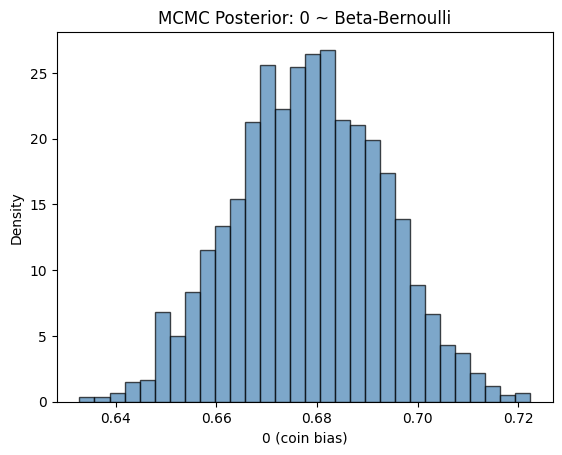

In [31]:
plt.hist(
    w_samples_MCMC,
    bins=30,
    density=True,
    alpha=0.7,
    color="steelblue",
    edgecolor="black"
)
plt.xlabel("0 (coin bias)")
plt.ylabel("Density")
plt.title("MCMC Posterior: 0 ~ Beta-Bernoulli")
plt.show()

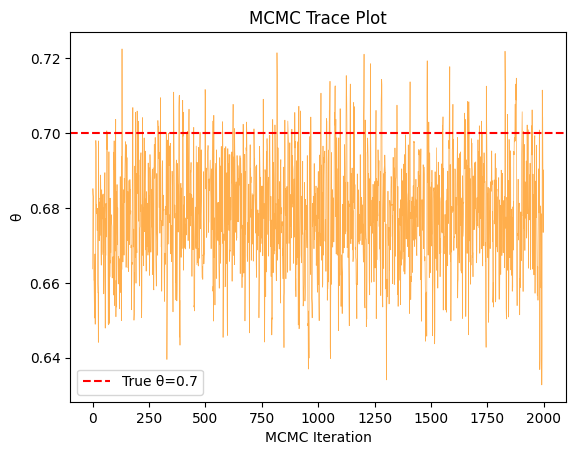

In [32]:
plt.plot(w_samples_MCMC, alpha=0.7, linewidth=0.5, color="darkorange")
plt.xlabel("MCMC Iteration")
plt.ylabel("θ")
plt.title("MCMC Trace Plot")
plt.axhline(true_w, color="red", linestyle="--", label=f"True θ={true_w}")
plt.legend()
plt.show()